In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install 'portalocker>=2.0.0'

In [ ]:
# for english language
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# for german language
!python3 -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 39.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


## Importing Libraries

In [ ]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [ ]:
# torch.cuda.get_device_name(0)

In [ ]:
torch.__version__

'2.1.0+cu121'

In [ ]:
torchtext.__version__

'0.16.0+cpu'

## Loading the Dataset

Here we are translating English to German.

In [ ]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'de'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [ ]:
#so this is a datapipe object
train

ShardingFilterIterDataPipe

## Exploratory Data Analysis

In [ ]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Two young, White males are outside near many bushes.',
 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')

In [ ]:
train_size = len(list(iter(train)))
train_size

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


29001

Since there are so many samples, we split them into train, validation and test.

In [ ]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [ ]:
train_size = len(list(iter(train)))
train_size

20301

In [ ]:
val_size = len(list(iter(val)))
val_size

5800

In [ ]:
test_size = len(list(iter(test)))
test_size

2900

## Preprocessing

### Tokenizing

Since we have two languages, let's create two different representations for tokens. Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word.

In [ ]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [ ]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [ ]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


Then we define a function to tokenize our input.

In [ ]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function that turn these tokens into integers. Here we use built-in function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknown', 'word', 'a'])

[1891, 10, 4, 5114, 3164, 4]

In [ ]:
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [ ]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [ ]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [ ]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [ ]:
#check unique vocabularies
len(mapping)

5174

## Preparing the dataloader

The <code>collate_fn</code> we used here also returns the length of sentence. It is required for <code>packed_padded_sequence</code>.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Then we create train, val, and test dataloaders.

In [ ]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's check the train loader.

In [ ]:
for en, _, de in train_loader:
    break

In [ ]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("German shape: ", de.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 24])
German shape:  torch.Size([64, 27])


## Designing the model

### Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli-head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}}

*   List item
*   List item

\big)V $$

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention


### Position-wise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## Training

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5174, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
   

In [ ]:
#we can print the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

1324544
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1646848
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1646848
  6433
______
8629537


In [ ]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

In [ ]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

Finally, we train our model.

In [ ]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.195 | Train PPL:  66.371
	 Val. Loss: 3.185 |  Val. PPL:  24.176
Epoch: 02 | Time: 0m 14s
	Train Loss: 2.890 | Train PPL:  17.993
	 Val. Loss: 2.570 |  Val. PPL:  13.061
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.304 | Train PPL:  10.013
	 Val. Loss: 2.245 |  Val. PPL:   9.440
Epoch: 04 | Time: 0m 15s
	Train Loss: 1.922 | Train PPL:   6.837
	 Val. Loss: 2.064 |  Val. PPL:   7.878
Epoch: 05 | Time: 0m 15s
	Train Loss: 1.640 | Train PPL:   5.154
	 Val. Loss: 1.961 |  Val. PPL:   7.106


## Plotting loss and accuracy

Text(0, 0.5, 'loss')

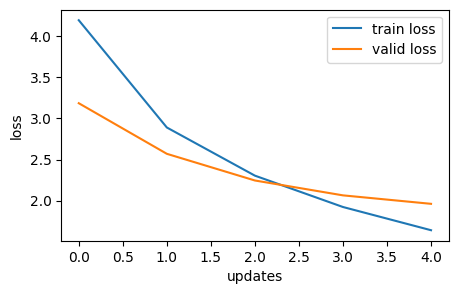

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.942 | Test PPL:   6.971 |


## Testing

In [ ]:
sample[0]

'Two young, White males are outside near many bushes.'

In [ ]:
sample[1]

'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'

In [ ]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   19,   25,   15, 1069,  842,   17,   56,   84,  331, 1623,    5,
           3], device='cuda:0')

In [ ]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   21,   83,  262,   32,   89,   22,   91,    7,   16,  115,    0,
        2893,    4,    3], device='cuda:0')

In [ ]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [ ]:
trg_text = trg_text.reshape(1, -1)

In [ ]:
src_text.shape, trg_text.shape

(torch.Size([1, 13]), torch.Size([1, 15]))

In [ ]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [ ]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text)

In [ ]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 15, 6433])

Since batch size is 1, we just take off that dimension.

In [ ]:
output = output.squeeze(0)

In [ ]:
output.shape

torch.Size([15, 6433])

Then we just take the top token with highest probabilities.

In [ ]:
output_max = output.argmax(1) #returns max indices

In [ ]:
output_max

tensor([ 21,  83,  32,  32,   9,  22,  91,  53,  16, 115,  24,  24,   4,   3,
          4], device='cuda:0')

We get the mapping of the target language.

In [ ]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [ ]:
for token in output_max:
    print(mapping[token.item()])

Zwei
junge
Männer
Männer
,
im
Freien
neben
der
Nähe
von
von
.
<eos>
.
